In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zeotape/Products.csv
/kaggle/input/zeotape/Customers.csv
/kaggle/input/zeotape/Transactions.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

In [3]:
customers=pd.read_csv('/kaggle/input/zeotape/Customers.csv')
transactions=pd.read_csv('/kaggle/input/zeotape/Transactions.csv')
products=pd.read_csv("/kaggle/input/zeotape/Products.csv")
transactions['TransactionDate']=pd.to_datetime(transactions['TransactionDate'])
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [4]:
# I did segmentation based on region, total money spent , total quanity,unique_product bought and number of transactions
customer_spending=transactions.groupby("CustomerID").agg(
    total_spent=("TotalValue","sum"),
    total_quantity=("Quantity", "sum"),
    unique_products=("ProductID", "nunique"),
    num_transactions=("TransactionID", "size") 
).reset_index()
df=customers.merge(customer_spending,on='CustomerID',how='left').fillna(0)
df=pd.get_dummies(df,columns=["Region"])
df_numeric=df.drop(['CustomerID','CustomerName','SignupDate'], axis=1)
df_numeric

,total_spent,total_quantity,unique_products,num_transactions,Region_Asia,Region_Europe,Region_North America,Region_South America
0,3354.52,12.0,5.0,5.0,False,False,False,True
1,1862.74,10.0,4.0,4.0,True,False,False,False
2,2725.38,14.0,4.0,4.0,False,False,False,True
3,5354.88,23.0,8.0,8.0,False,False,False,True
4,2034.24,7.0,3.0,3.0,True,False,False,False
...,...,...,...,...,...,...,...,...
195,4982.88,12.0,3.0,4.0,False,True,False,False
196,1928.65,9.0,3.0,3.0,False,True,False,False
197,931.83,3.0,2.0,2.0,False,True,False,False
198,1979.28,9.0,4.0,4.0,False,True,False,False


In [5]:
X=df_numeric.copy()
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

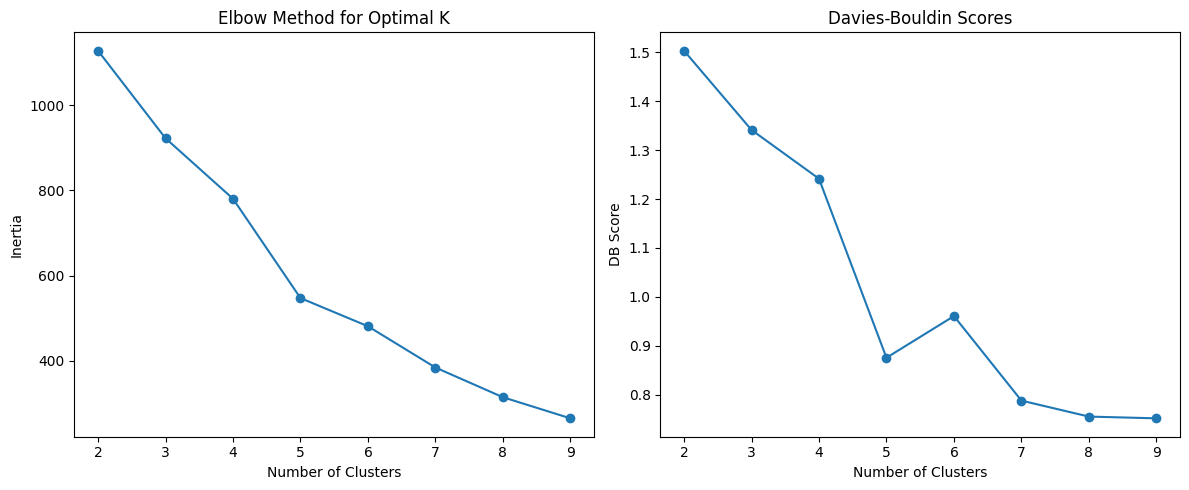

Optimal Number of Clusters based on DB Index: 9
Final DB Index: 0.7314541407681125


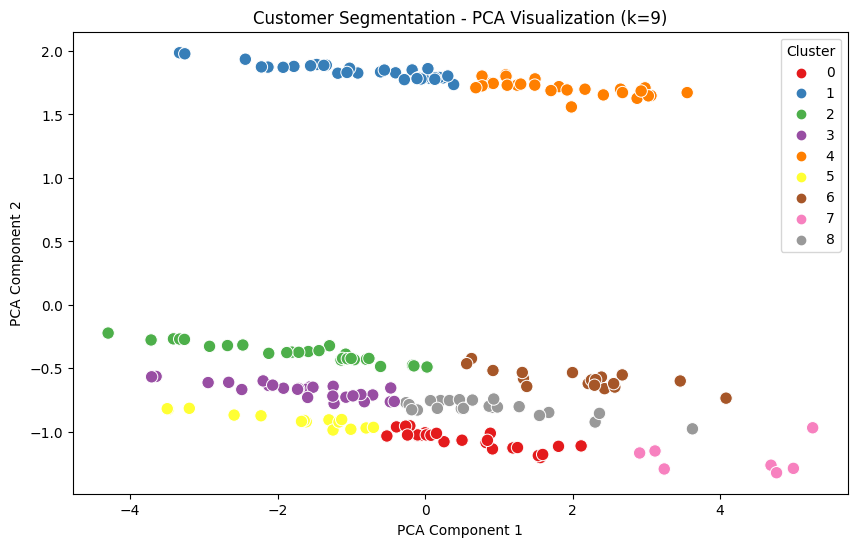

In [6]:
inertia = []
db_scores = []
for k in range(2, 10):
    kmeans=KMeans(n_clusters=k,random_state=5,n_init=2)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    labels=kmeans.labels_
    db_score=davies_bouldin_score(X_scaled, labels)
    db_scores.append(db_score)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 10), db_scores, marker='o')
plt.title('Davies-Bouldin Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Score')

plt.tight_layout()
plt.show()

optimal_k = range(2, 10)[np.argmin(db_scores)]
print(f"Optimal Number of Clusters based on DB Index: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
X['Cluster'] = kmeans.fit_predict(X_scaled)

final_db_index = davies_bouldin_score(X_scaled, X['Cluster'])
print(f"Final DB Index: {final_db_index}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X['Cluster'], palette='Set1', s=80)
plt.title(f'Customer Segmentation - PCA Visualization (k={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.show()